In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def grouped_boxplot(groups, regions, params=None, pval_func=None):
    defaults = {
        "colors": ["skyblue", "salmon"],       # colors for main data
        "null_colors": ["lightgrey", "darkgrey", "silver"],  # colors for null models
        "figsize": (8, 5),
        "title": "Grouped Boxplots",
        "ylabel": "Value",
        "group_gap": 1.5,
        "pair_gap": 0.2,
        "box_width": 0.15,
        "null_box_width": 0.1,                # NEW: narrower null boxes
        "box_linewidth": 1.5,
        "legend_labels": ["GCaMP=False", "GCaMP=True"],
        "null_legend_labels": ["Null model 1", "Null model 2"],  # NEW
        "pval_fontsize": 10,
        "pval_y_offset": 0.05,
        "pval_indices": (0, 1),               # NEW: which datasets to compare
        "y0_line": True
    }
    if params is not None:
        defaults.update(params)
    p = defaults

    fig, ax = plt.subplots(figsize=p["figsize"])
    positions, box_data, color_list, widths = [], [], [], []

    pos = 1
    for g in groups:
        n_main = len(p["colors"])
        n_null = len(g) - n_main

        # --- sanity check ---
        if len(g) < n_main:
            raise ValueError("Each group must have at least as many datasets as colors (main boxes).")

        # main boxes
        for i in range(n_main):
            box_data.append(g[i])
            positions.append(pos + i * p["pair_gap"])
            color_list.append(p["colors"][i])
            widths.append(p["box_width"])

        # null boxes
        for j in range(n_null):
            box_data.append(g[n_main + j])
            positions.append(pos + n_main * p["pair_gap"] + (j + 1) * p["pair_gap"])
            color_list.append(p["null_colors"][j % len(p["null_colors"])])
            widths.append(p["null_box_width"])

        # move to next group
        pos += n_main + n_null + p["group_gap"]

    # ---- Create boxplots ----
    bp = ax.boxplot(
        box_data,
        positions=positions,
        widths=widths,
        patch_artist=True,
        medianprops=dict(color='black', linewidth=p["box_linewidth"]),
        boxprops=dict(linewidth=p["box_linewidth"]),
        whiskerprops=dict(linewidth=p["box_linewidth"]),
        capprops=dict(linewidth=p["box_linewidth"]),
    )

    # ---- Apply colors ----
    for patch, c in zip(bp['boxes'], color_list):
        patch.set_facecolor(c)
        patch.set_edgecolor('black')

    # ---- Grey dashed line at y=0 ----
    if p["y0_line"]:
        ax.axhline(0, color="lightgrey", linestyle="--", linewidth=1)

    # ---- Axis labels ----
    xtick_positions = []
    pos_idx = 0
    for g in groups:
        n = len(g)
        xtick_positions.append(np.mean(positions[pos_idx:pos_idx + n]))
        pos_idx += n
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(regions)
    ax.set_xlim(min(positions) - 0.5, max(positions) + 0.5)
    ax.set_ylabel(p["ylabel"])
    ax.set_title(p["title"])

    # ---- P-values ----
    if pval_func is not None:
        for i, g in enumerate(groups):
            i1, i2 = p["pval_indices"]
            if len(g) <= max(i1, i2):
                continue  # skip if not enough data for pval
            try:
                pval = pval_func(g[i1], g[i2])
            except Exception as e:
                pval = np.nan
                print(f"Warning: failed to compute p-value for group {regions[i]} ({e})")

            xpos = xtick_positions[i]
            y_max = np.nanmax([np.nanmax(arr) if len(arr) else 0 for arr in g])
            y_text = y_max + abs(y_max) * p["pval_y_offset"]
            ax.text(
                xpos, y_text,
                f"p = {pval:.3g}" if not np.isnan(pval) else "p = n/a",
                ha='center', va='bottom',
                fontsize=p["pval_fontsize"]
            )

    # ---- Legend ----
    handles = [
        plt.Line2D([0], [0], color=c, lw=6, label=lbl)
        for c, lbl in zip(p["colors"], p["legend_labels"])
    ]
    if any(len(g) > len(p["colors"]) for g in groups):
        for c, lbl in zip(p["null_colors"], p["null_legend_labels"]):
            handles.append(plt.Line2D([0], [0], color=c, lw=6, label=lbl))
    ax.legend(handles=handles, title="Condition")

    plt.tight_layout()
    return fig


# ---------------------------
# CSV-to-boxplot logic
# ---------------------------

def plot_csv_groups(filenames, regions, column, null_filenames=None, params=None, pval_func=None):
    """
    Create grouped boxplots from CSV files, optionally including null model data.

    Parameters
    ----------
    filenames : list[str]
        List of main CSV filenames, one per group. Each must contain 'GCaMP' column.
    regions : list[str]
        Labels for each group on the x-axis.
    column : str
        Column name to extract from each CSV for plotting.
    null_filenames : list[list[str]] or None
        Nested list of null model filenames corresponding to each group.
        Example: [["null1a.csv", "null1b.csv"], ["null2a.csv"], []]
    params : dict or None
        Optional parameters for plot appearance.
    pval_func : callable or None
        Function for computing p-values between selected datasets.
    """
    groups = []

    for i, fname in enumerate(filenames):
        df = pd.read_csv(fname)
        if "GCaMP" not in df.columns:
            raise ValueError(f"'GCaMP' column missing in {fname}")
        if column not in df.columns:
            raise ValueError(f"'{column}' column missing in {fname}")

        # Main data: split into False and True groups
        data_false = df.loc[df["GCaMP"] == False, column].dropna().values
        data_true = df.loc[df["GCaMP"] == True, column].dropna().values

        group = [data_false, data_true]

        # ---- Add null models if provided ----
        if null_filenames is not None and i < len(null_filenames):
            for null_file in null_filenames[i]:
                ndf = pd.read_csv(null_file)
                if "GCaMP" not in ndf.columns:
                    raise ValueError(f"'GCaMP' column missing in null model file {null_file}")
                if column not in ndf.columns:
                    raise ValueError(f"'{column}' column missing in null model file {null_file}")
                
                # Only use GCaMP=True rows for null models
                null_data = ndf.loc[ndf["GCaMP"] == True, column].dropna().values
                group.append(null_data)

        groups.append(tuple(group))

    fig = grouped_boxplot(groups, regions, params, pval_func=pval_func)
    return fig

# Example: use Mann-Whitney U test as p-value function
def pval_func(a, b):
    if len(a) == 0 or len(b) == 0:
        return np.nan
    _, pval = stats.mannwhitneyu(a, b, alternative="two-sided")
    return pval


In [26]:
def return_dataframe(filename):
    return pd.read_csv(filename).set_index("id")

def save_dataframe(df, filename):
    df.to_csv(filename)

# PARAMETERS

In [27]:
data_folder = f"C:/Users/torte/Downloads/new_df"
regions = ["Motor_left", "Motor_right", "Somatosensory_left", "Somatosensory_right", "Retrosplenial_left", "Retrosplenial_right", "Visual_left", "Visual_right"]
file_id = "v2_trim_mvmt"

# Neurovascular coupling

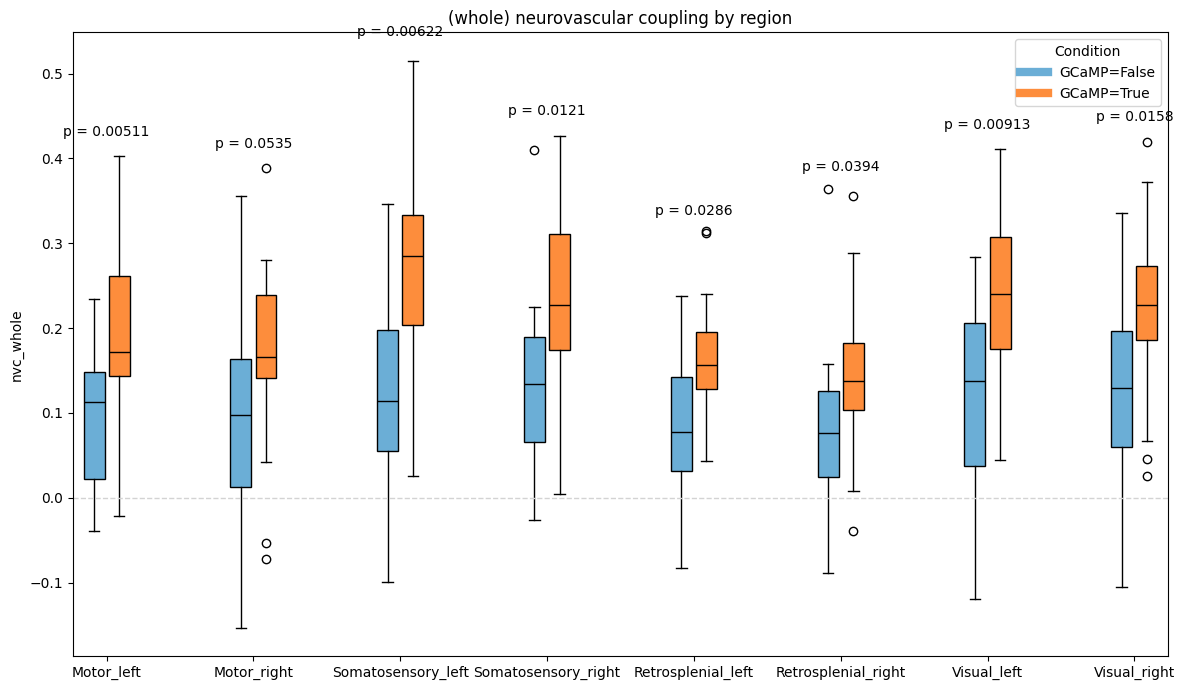

In [28]:
params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(whole) neurovascular coupling by region",
    "ylabel": "nvc_whole",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6
}

files = [os.path.join(data_folder, f"nvc_region_{region}_{file_id}_df.csv") for region in regions]
# null_filenames = [[os.path.join(data_folder, f"nvc_region_{region}_v2_null_shuffle_df.csv")] for region in regions]
null_filenames = None

fig = plot_csv_groups(files, regions, column="nvc_whole", params=params, pval_func=pval_func, null_filenames=null_filenames)
plt.show()

# Functional similarity

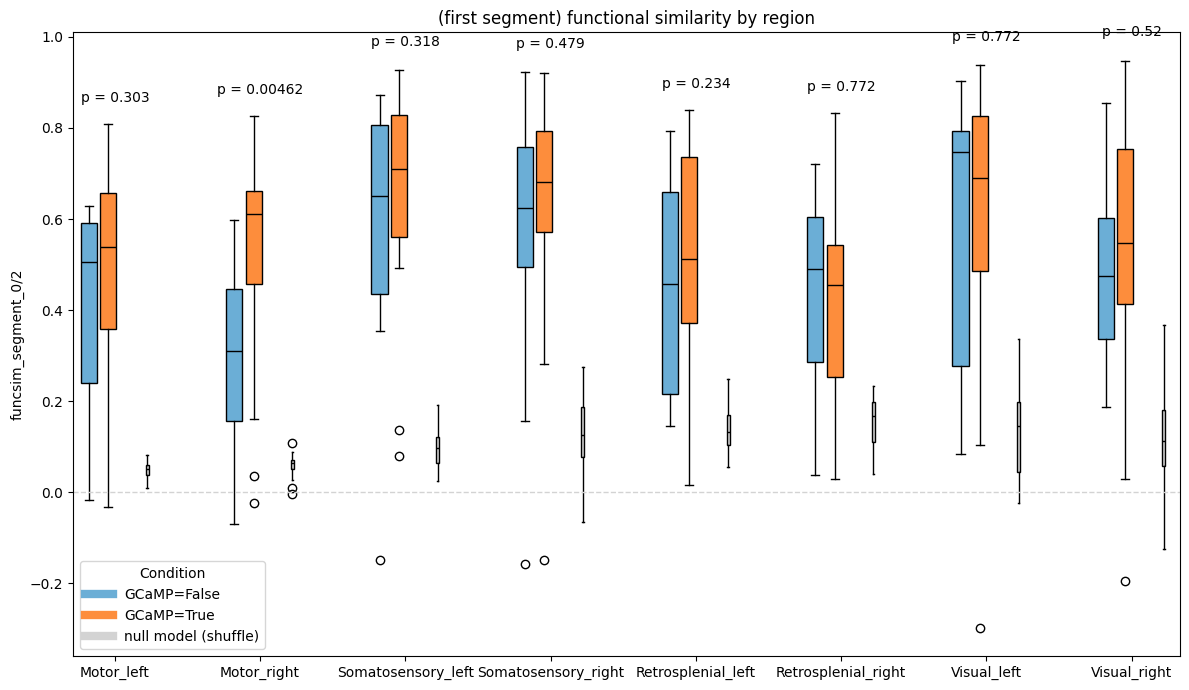

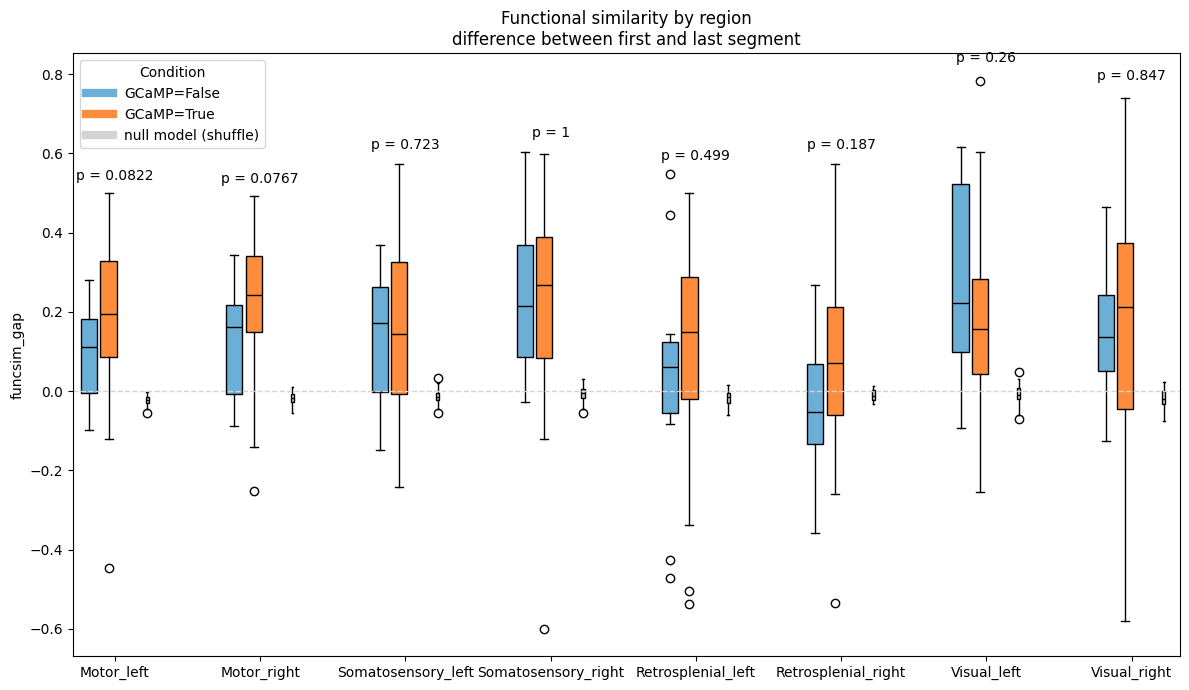

In [29]:
params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(first segment) functional similarity by region",
    "ylabel": "funcsim_segment_0/2",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"funcsim_region_{region}_{file_id}_df.csv") for region in regions]
null_filenames = [[os.path.join(data_folder, f"funcsim_region_{region}_v2_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="funcsim_segment_0/2", params=params, pval_func=pval_func, null_filenames=null_filenames)
plt.show()


########################

for region in regions:
    for id in [file_id, "v2_null_shuffle"]:

        filename = os.path.join(data_folder, f"funcsim_region_{region}_{id}_df.csv")
        df = return_dataframe(filename)
        df["funcsim_gap"] = df["funcsim_segment_0/2"] - df["funcsim_segment_1/2"]
        save_dataframe(df, os.path.join(data_folder, f"funcsim_region_{region}_{id}_df.csv"))

params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "Functional similarity by region\ndifference between first and last segment",
    "ylabel": "funcsim_gap",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"funcsim_region_{region}_{file_id}_df.csv") for region in regions]
null_filenames = [[os.path.join(data_folder, f"funcsim_region_{region}_v2_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="funcsim_gap", params=params, pval_func=pval_func, null_filenames=null_filenames)
plt.show()


# Functional representativity

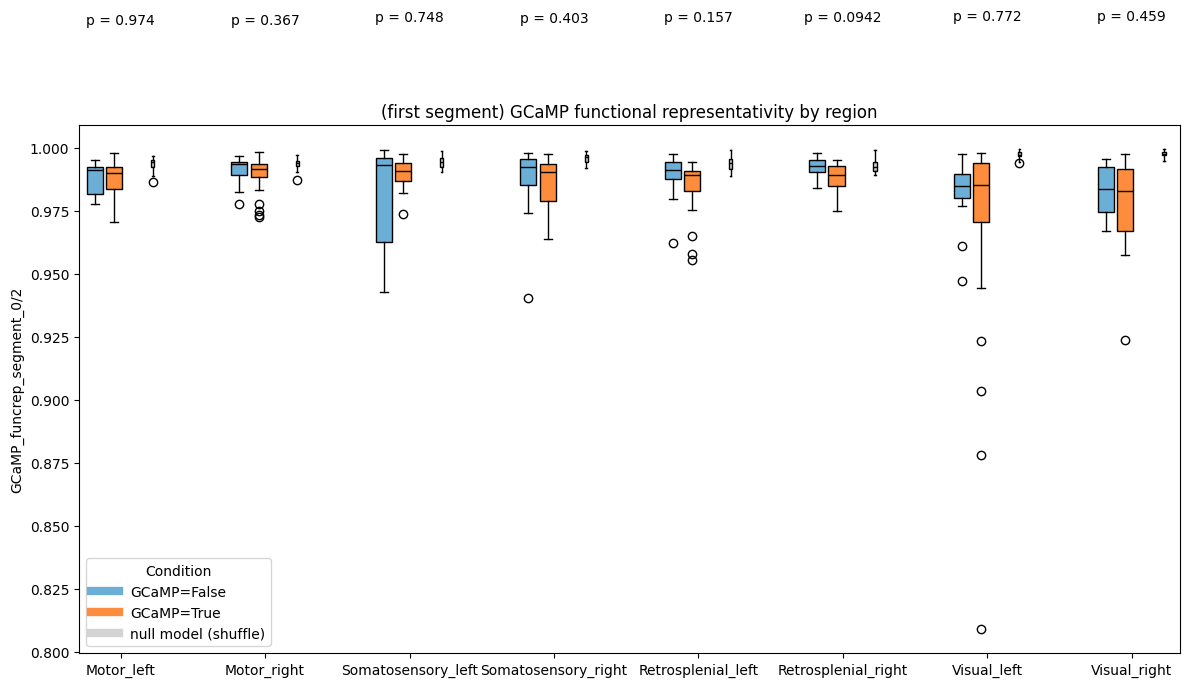

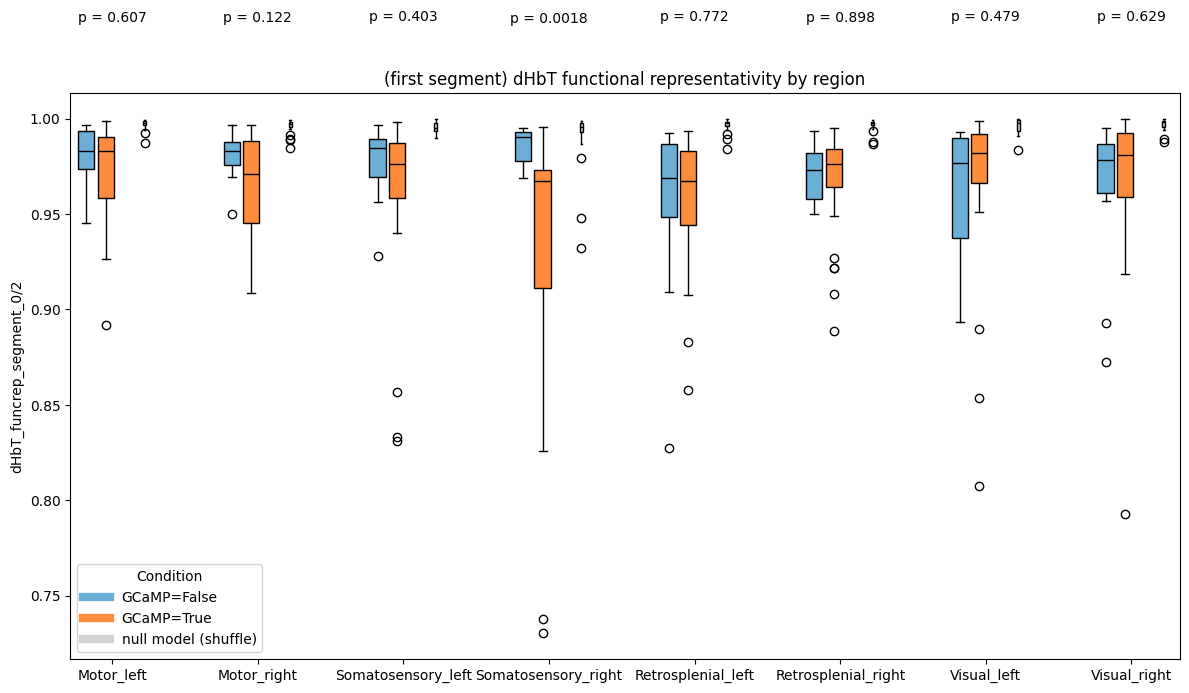

In [30]:
params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(first segment) GCaMP functional representativity by region",
    "ylabel": "GCaMP_funcrep_segment_0/2",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "y0_line": False,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"funcrep_region_{region}_{file_id}_df.csv") for region in regions]
null_filenames = [[os.path.join(data_folder, f"funcrep_region_{region}_v2_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="GCaMP_funcrep_segment_0/2", params=params, pval_func=pval_func, null_filenames=null_filenames)
plt.show()



#####################


params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(first segment) dHbT functional representativity by region",
    "ylabel": "dHbT_funcrep_segment_0/2",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "y0_line": False,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"funcrep_region_{region}_{file_id}_df.csv") for region in regions]
null_filenames = [[os.path.join(data_folder, f"funcrep_region_{region}_v2_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="dHbT_funcrep_segment_0/2", params=params, pval_func=pval_func, null_filenames=null_filenames)
plt.show()

# Modularity

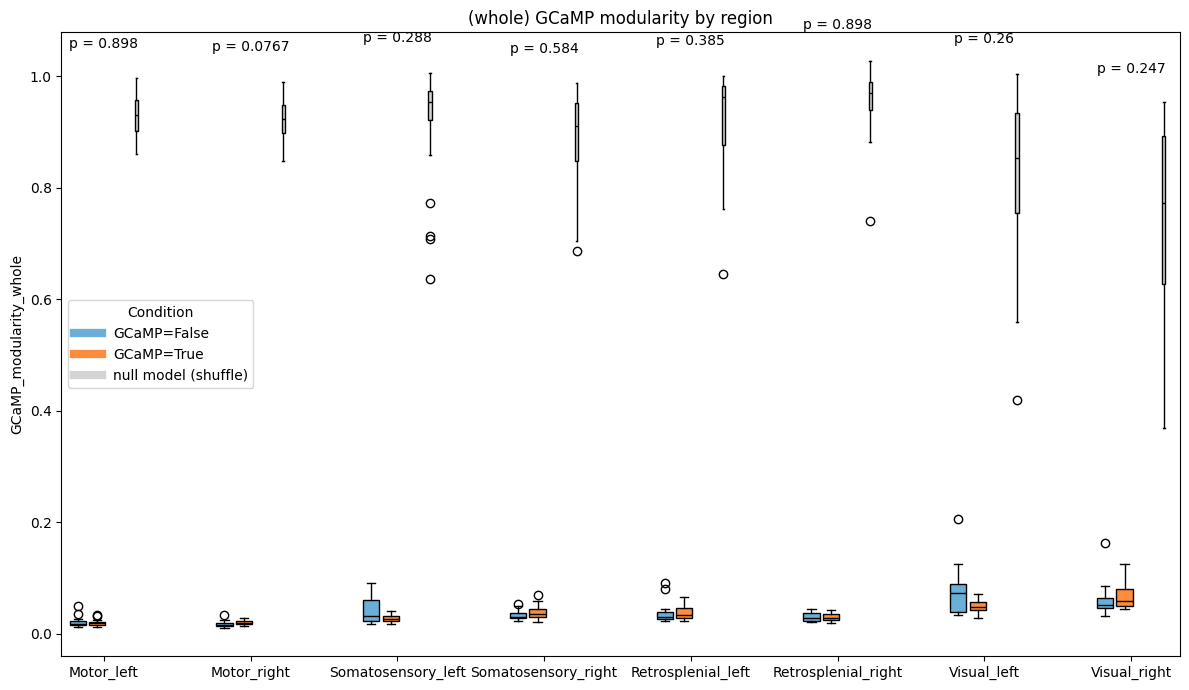

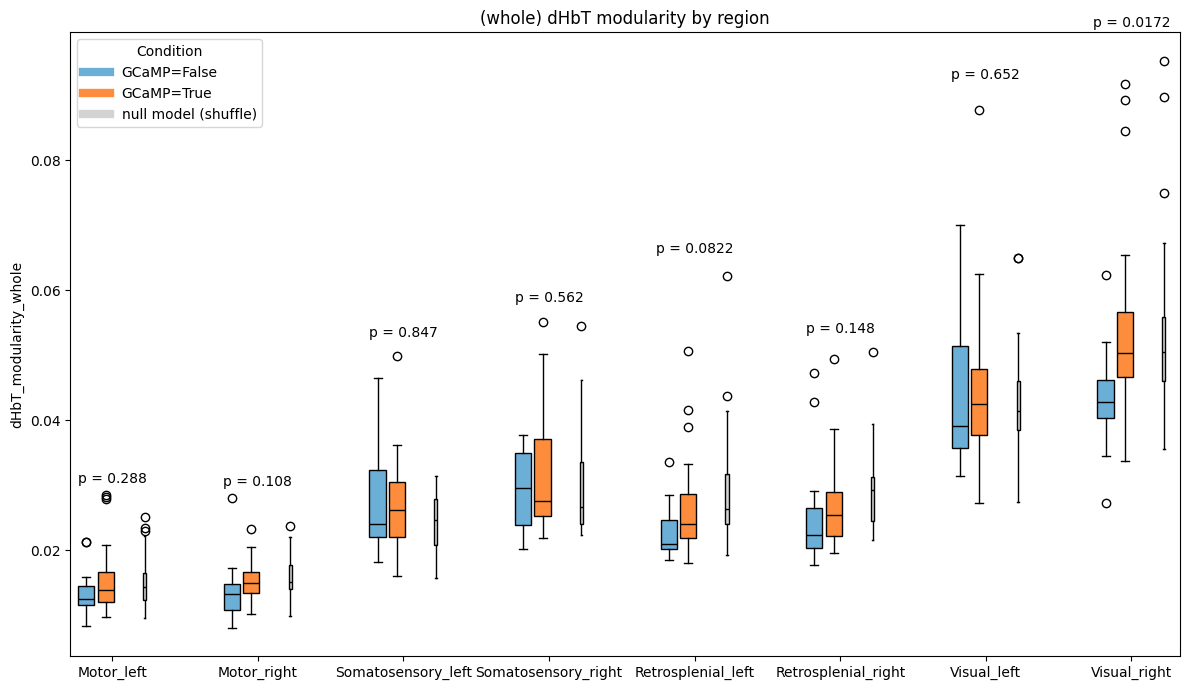

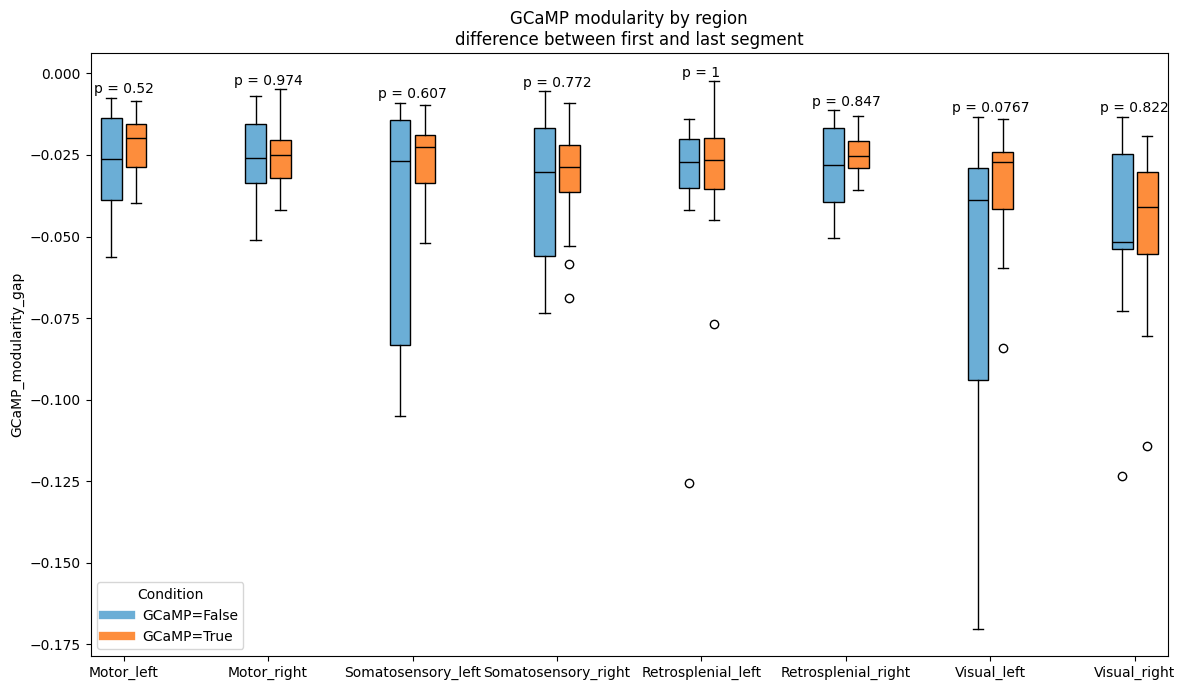

In [31]:
params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(whole) GCaMP modularity by region",
    "ylabel": "GCaMP_modularity_whole",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "y0_line": False,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"modularity_region_{region}_{file_id}_df.csv") for region in regions]
null_filenames = [[os.path.join(data_folder, f"modularity_region_{region}_v2_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="GCaMP_modularity_whole", params=params, pval_func=pval_func, null_filenames=null_filenames)
plt.show()



#####################


params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(whole) dHbT modularity by region",
    "ylabel": "dHbT_modularity_whole",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "y0_line": False,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"modularity_region_{region}_{file_id}_df.csv") for region in regions]
null_filenames = [[os.path.join(data_folder, f"modularity_region_{region}_v2_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="dHbT_modularity_whole", params=params, pval_func=pval_func, null_filenames=null_filenames)
plt.show()


##############################


for region in regions:
    for id in [file_id, "v2_null_shuffle"]:

        filename = os.path.join(data_folder, f"modularity_region_{region}_{id}_df.csv")
        df = return_dataframe(filename)
        df["GCaMP_modularity_gap"] = df["GCaMP_modularity_segment_0/2"] - df["GCaMP_modularity_segment_1/2"]
        save_dataframe(df, os.path.join(data_folder, f"modularity_region_{region}_{id}_df.csv"))


params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "GCaMP modularity by region\ndifference between first and last segment",
    "ylabel": "GCaMP_modularity_gap",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6,
    "y0_line": False,
    "null_legend_labels": ["null model (shuffle)"]
}

files = [os.path.join(data_folder, f"modularity_region_{region}_{file_id}_df.csv") for region in regions]
# null_filenames = [[os.path.join(data_folder, f"modularity_region_{region}_v2_null_shuffle_df.csv")] for region in regions]

fig = plot_csv_groups(files, regions, column="GCaMP_modularity_gap", params=params, pval_func=pval_func, null_filenames=None)
plt.show()

# TESTS

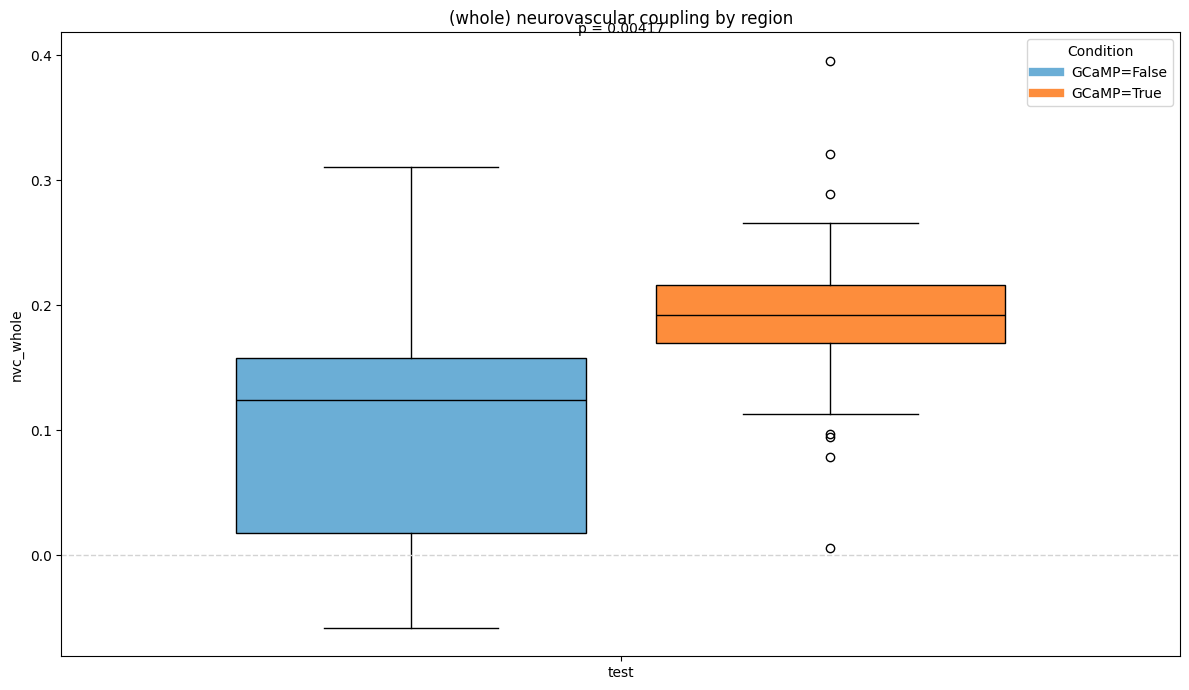

In [32]:
def plot_csv_groups(filenames, regions, column, null_filenames=None, params=None, pval_func=None):
    """
    Create grouped boxplots from CSV files, optionally including null model data.

    Parameters
    ----------
    filenames : list[str]
        List of main CSV filenames, one per group. Each must contain 'GCaMP' column.
    regions : list[str]
        Labels for each group on the x-axis.
    column : str
        Column name to extract from each CSV for plotting.
    null_filenames : list[list[str]] or None
        Nested list of null model filenames corresponding to each group.
        Example: [["null1a.csv", "null1b.csv"], ["null2a.csv"], []]
    params : dict or None
        Optional parameters for plot appearance.
    pval_func : callable or None
        Function for computing p-values between selected datasets.
    """
    groups = []

    for i, fname in enumerate(filenames):
        df = pd.read_csv(fname)
        if "GCaMP" not in df.columns:
            raise ValueError(f"'GCaMP' column missing in {fname}")
        if column not in df.columns:
            raise ValueError(f"'{column}' column missing in {fname}")

        # Main data: split into False and True groups
        data_false = df.loc[df["GCaMP"] == False, column].dropna().values
        data_true = df.loc[df["GCaMP"] == True, column].dropna().values

        group = [data_false, data_true]

        # ---- Add null models if provided ----
        if null_filenames is not None and i < len(null_filenames):
            for null_file in null_filenames[i]:
                ndf = pd.read_csv(null_file)
                if "GCaMP" not in ndf.columns:
                    raise ValueError(f"'GCaMP' column missing in null model file {null_file}")
                if column not in ndf.columns:
                    raise ValueError(f"'{column}' column missing in null model file {null_file}")
                
                # Only use GCaMP=True rows for null models
                null_data = ndf.loc[ndf["GCaMP"] == True, column].dropna().values
                group.append(null_data)

        groups.append(tuple(group))

    fig = grouped_boxplot(groups, regions, params, pval_func=pval_func)
    return fig



params = {
    "colors": ["#6baed6", "#fd8d3c"],
    "title": "(whole) neurovascular coupling by region",
    "ylabel": "nvc_whole",
    "figsize": (12, 7),
    "legend_labels": ["GCaMP=False", "GCaMP=True"],
    "box_linewidth": 1,  # thicker boxe lines,
    "box_width": 0.5,
    "pair_gap": 0.6
}

files = [os.path.join(data_folder, f"nvc_whole_v2_trim_mvmt_df.csv")]
# null_filenames = [[os.path.join(data_folder, f"nvc_region_{region}_v2_null_shuffle_df.csv")] for region in regions]
null_filenames = None

fig = plot_csv_groups(files, regions=["test"], column="nvc_whole", params=params, pval_func=pval_func, null_filenames=null_filenames)
plt.show()